In [1]:
from ase.build import fcc111, bulk, add_adsorbate
from ase.calculators.emt import EMT
from ase.optimize import BFGS, MDMin
from ase.visualize import view
from ase import io
from ase.neb import NEB
from ase.io.trajectory import Trajectory
from ase.constraints import FixAtoms
from ase.db import connect
from utils.cont_train_agent_Pt_surf_frs import BPNN, Agent, get_scaling
from utils.fp_calculator import set_sym, calculate_fp, db_to_fp
from utils.NN_calc import NN_Calc
import numpy as np
import torch
import os

### Set hyperparameters

In [2]:
# global parameters like symm func, work folder, device, NN structure
elements = ['Pt']

Gs = [2, 4]
cutoff = 6.0
g2_etas = [0.05, 4.0, 20.0, 80.0]
g2_Rses = [0.0]
g4_etas = [0.005]
g4_zetas = [1.0, 4.0]
g4_lambdas = [-1.0, 1.0]

params_set = set_sym(elements, Gs, cutoff, g2_etas=g2_etas, g2_Rses=g2_Rses,
                     g4_etas=g4_etas, g4_zetas=g4_zetas, g4_lambdas=g4_lambdas)

Name = 'Pt-3g2-4g4'
device = torch.device('cpu')

layer_nodeses = [[50, 50]] * 10
activations = [['tanh', 'tanh']] * 10
lrs = [1] * 10
ensemble_size = 10

### Train initial NN using some initial images
Not all of the initial images are used to train the initial NNs

In [32]:
# create confident model for the initial bands
N_curr = 0  # NEB iteration
sub_N = 0  # iteration of active learning for the initial band

# init_db = connect('./datasets/Pt-init-images.db')
init_db = connect('./datasets/Pt-init-images-after-step0.db')  # use the new initial guess
init_images = [entry.toatoms() for entry in init_db.select()]
curr_train_db = connect(f'./datasets/Pt-step{N_curr}-{sub_N}-train.db')
# use the initial image, final image and several intermediate image as the initial training set
s_ids = [0, 3, 5, 8, 10]

for i in s_ids:
    temp_image = init_images[i]
    temp_image.set_calculator(EMT())
    temp_nrg = temp_image.get_potential_energy()
    curr_train_db.write(temp_image)

# train iniital NN model using initial images
train_data = db_to_fp(curr_train_db, params_set)
torch.save(train_data, f'{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
scale_file = f'{Name}/scale-after-step{N_curr}-{sub_N}.sav'
scale = get_scaling(train_data)
torch.save(scale, scale_file)

train_data = torch.load(f'./{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
valid_data = torch.load(f'./{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
scale_file = f'./{Name}/scale-after-step{N_curr}-{sub_N}.sav'
scale = torch.load(scale_file)

train_data['b_fp'] = (train_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)
valid_data['b_fp'] = (valid_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)
train_data['b_dfpdX'] /= (scale['fp_max'] - scale['fp_min'] + 1e-10).view(1, 1, -1, 1, 1)
valid_data['b_dfpdX'] /= (scale['fp_max'] - scale['fp_min'] + 1e-10).view(1, 1, -1, 1, 1)

for key in train_data.keys():
    train_data[key] = train_data[key].to(device)
    valid_data[key] = valid_data[key].to(device)
    

subpath = f'model-after-step{N_curr}'
if not os.path.isdir(f'{Name}/{subpath}'):
    os.mkdir(f'{Name}/{subpath}')
model_paths = [f'./{Name}/{subpath}/model_{m}.sav' for m in range(ensemble_size)]
log_names = [f'./{Name}/{subpath}/log_{m}.txt' for m in range(ensemble_size)]

print(f'step-{N_curr}-sub-{sub_N}-training', flush=True)
for m in range(ensemble_size):
    print(f'model {m}')
    agent = Agent(train_data=train_data, valid_data=valid_data, model_path=model_paths[m], test_data=None,
                  layer_nodes=layer_nodeses[m], activation=activations[m], lr=lrs[m],
                  max_iter=10, history_size=100, device=device)
    rsts = agent.train(log_name=log_names[m], n_epoch=300, interupt=True, val_interval=10,
                       is_force=True, nrg_convg=1.5, force_convg=5, max_frs_convg=35, nrg_coef=1000, force_coef=50)

step-0-sub-0-training
model 0
model 1
model 2
model 3
model 4
model 5
model 6
model 7
model 8
model 9


### Evaluate the unceratinty on initial images
If the max std on the initial images is larger than 3 times of the maximum std of the training set, then conduct active learning on the initial band until the model are certain on all of the initial images.

In [33]:
# evaluate uncertainty on the initial band
n_fp = len(params_set[elements[0]]['i'])
models_list = []
for m in range(ensemble_size):
    model = BPNN(n_fp, layer_nodeses[m], activations[m], len(elements))
    model_path = f'./{Name}/{subpath}/model_{m}.sav'
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    models_list.append(model)

scale = torch.load(f'./{Name}/scale-after-step{N_curr}-{sub_N}.sav')

train_stds = []
for entry in curr_train_db.select():
    image = entry.toatoms()
    image.set_calculator(NN_Calc(params_set=params_set, models_list=models_list,
                                 scale=scale, elements=elements))
    image.get_potential_energy()
    train_stds.append(image.calc.results['free_energy'])
max_train_std = np.max(train_stds)

init_stds = []
for entry in init_db.select():
    image = entry.toatoms()
    image.set_calculator(NN_Calc(params_set=params_set, models_list=models_list,
                                 scale=scale, elements=elements))
    image.get_potential_energy()
    init_stds.append(image.calc.results['free_energy'])


In [34]:
# active learning on initial band if needed
while max(init_stds) > 3 * max_train_std:
    print('There is uncertain image in the initial band, conduct active learning')
    max_id = np.argmax(init_stds)
    max_image = list(init_db.select())[max_id].toatoms()
    max_image.set_calculator(EMT())
    max_image.get_potential_energy()
    sub_N += 1
    curr_train_db = connect(f'./datasets/Pt-step{N_curr}-{sub_N}-train.db')
    last_train_db = connect(f'./datasets/Pt-step{N_curr}-{sub_N-1}-train.db')
    for entry in last_train_db:
        curr_train_db.write(entry)
    curr_train_db.write(max_image)
    train_data = db_to_fp(curr_train_db, params_set)
    torch.save(train_data, f'{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
    scale_file = f'{Name}/scale-after-step{N_curr}-{sub_N}.sav'
    scale = get_scaling(train_data)
    torch.save(scale, scale_file)

    train_data = torch.load(f'./{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
    valid_data = torch.load(f'./{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
    scale_file = f'./{Name}/scale-after-step{N_curr}-{sub_N}.sav'
    scale = torch.load(scale_file)

    train_data['b_fp'] = (train_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)
    valid_data['b_fp'] = (valid_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)
    train_data['b_dfpdX'] /= (scale['fp_max'] - scale['fp_min'] + 1e-10).view(1, 1, -1, 1, 1)
    valid_data['b_dfpdX'] /= (scale['fp_max'] - scale['fp_min'] + 1e-10).view(1, 1, -1, 1, 1)

    for key in train_data.keys():
        train_data[key] = train_data[key].to(device)
        valid_data[key] = valid_data[key].to(device)

    subpath = f'model-after-step{N_curr}'
    model_paths = [f'./{Name}/{subpath}/model_{m}.sav' for m in range(ensemble_size)]
    log_names = [f'./{Name}/{subpath}/log_{m}.txt' for m in range(ensemble_size)]
    print(f'step-{N_curr}-sub-{sub_N}-training', flush=True)
    for m in range(ensemble_size):
        print(f'model {m}')
        agent = Agent(train_data=train_data, valid_data=valid_data, model_path=model_paths[m], test_data=None, 
                        layer_nodes=layer_nodeses[m], activation=activations[m], lr=lrs[m], 
                        max_iter=10, history_size=100, device=device)
        rsts = agent.train(log_name=log_names[m], n_epoch=300, interupt=True, val_interval=1, 
                            is_force=True, nrg_convg=1.5, force_convg=5, max_frs_convg=35, nrg_coef=1000, force_coef=50)

    # evaluate uncertainty on the initial band
    n_fp = len(params_set[elements[0]]['i'])
    models_list = []
    for m in range(ensemble_size):
        model = BPNN(n_fp, layer_nodeses[m], activations[m], len(elements))
        model_path = f'./{Name}/{subpath}/model_{m}.sav'
        model.load_state_dict(torch.load(
            model_path, map_location=torch.device('cpu')))
        models_list.append(model)

    scale = torch.load(f'./{Name}/scale-after-step{N_curr}-{sub_N}.sav')

    train_stds = []
    for entry in curr_train_db.select():
        image = entry.toatoms()
        image.set_calculator(NN_Calc(params_set=params_set, models_list=models_list,
                                    scale=scale, elements=elements))
        image.get_potential_energy()
        train_stds.append(image.calc.results['free_energy'])
    max_train_std = np.max(train_stds)

    init_stds = []
    for entry in init_db.select():
        image = entry.toatoms()
        image.set_calculator(NN_Calc(params_set=params_set, models_list=models_list,
                                    scale=scale, elements=elements))
        image.get_potential_energy()
        init_stds.append(image.calc.results['free_energy'])

Some forces in the initial images are too large, which makes it hard to train NN with high accuracy, thus we firstly conduct some relaxation using the initial NN (within the certain range of the NN). Then use the relaxed images as the new guess of the initial band, repeat the above cells for one time.

In [ ]:
# skip this cell if the initial band has been relaxed
init_db = connect('./datasets/Pt-init-images.db')
init_images = [entry.toatoms() for entry in init_db.select()]

neb = NEB(init_images, k=1, climb=True)
n_inter_images = 9

subpath = f'model-after-step{N_curr}'
n_fp = len(params_set[elements[0]]['i'])
models_list = []
for m in range(ensemble_size):
    model = BPNN(n_fp, layer_nodeses[m], activations[m], len(elements))
    model_path = f'./{Name}/{subpath}/model_{m}.sav'
    model.load_state_dict(torch.load(
        model_path, map_location=torch.device('cpu')))
    models_list.append(model)
scale = torch.load(f'./{Name}/scale-after-step{N_curr}-{sub_N}.sav')

# Set calculators:
for image in init_images[1:1+n_inter_images]:
    image.set_calculator(NN_Calc(params_set=params_set, models_list=models_list, 
                                scale=scale, elements=elements))
# Optimize:
optimizer = MDMin(neb, trajectory=f'./datasets/Pt-NN-after-step{N_curr}.traj',
                logfile=f'./datasets/NN-step{N_curr}-MDMin.txt')
is_nn_cnvg = optimizer.run(fmax=0.05, steps=100)

nn_calc = NN_Calc(params_set=params_set, models_list=models_list,
                  scale=scale, elements=elements)
nrgs = []
stds = []
for entry in curr_train_db.select():
    image = entry.toatoms()
    image.set_calculator(nn_calc)
    image.get_potential_energy()
    nrgs.append(image.calc.results['energy'])
    stds.append(image.calc.results['free_energy'])
nrgs = np.asarray(nrgs)
stds = np.asarray(stds)
max_train_std = np.max(stds)

# check NEB uncertainty
is_all_certain = True
traj = Trajectory(f'./datasets/Pt-NN-after-step{N_curr}.traj', 'r')
traj = list(traj)
neb_stds = []
neb_nrgs = []
neb_images = []
for i in range(1, 101):
    if i*(2+n_inter_images) >= len(traj):
        break
    temp_images = traj[i*(2+n_inter_images):(i+1)*(2+n_inter_images)]
    temp_stds = []
    temp_nrgs = []
    for t_image in temp_images:
        t_image.set_calculator(nn_calc)
        t_image.get_potential_energy()
        temp_stds.append(t_image.calc.results['free_energy'])
        temp_nrgs.append(t_image.calc.results['energy'])
    neb_stds.append(temp_stds)
    neb_nrgs.append(temp_nrgs)
    neb_images.append(temp_images)
    if np.max(temp_stds) > 3 * max_train_std:
        is_all_certain = False
        break

new_initial_db = connect('./datasets/Pt-init-images-after-step0.db')
if np.max(neb_stds[-1]) > 3 * max_train_std:
    for image in neb_images[-2]:
        image.set_calculator(None)
        new_initial_db.write(image)
else:
    for image in neb_images[-1]:
        image.set_calculator(None)
        new_initial_db.write(image)

In [35]:
# rename the final step0 training db
curr_train_db_temp = connect(f'./datasets/Pt-step{N_curr}-{sub_N}-train.db')
curr_train_db = connect(f'./datasets/Pt-step{N_curr}-train.db')
for entry in curr_train_db_temp.select():
    curr_train_db.write(entry)
print('initial images are certain, conduct neb')

initial images are certain, conduct neb


### NN ensemble NEB

In [36]:

# now we have a confident model on the initial band, we can use it to do NEB
is_cnvg = False
while not is_cnvg:
    # load trained models and conduct NEB
    init_db = connect('./datasets/Pt-init-images-after-step0.db')
    init_images = [entry.toatoms() for entry in init_db.select()]

    neb = NEB(init_images, k=1, climb=True)
    n_inter_images = 9

    subpath = f'model-after-step{N_curr}'
    n_fp = len(params_set[elements[0]]['i'])
    models_list = []
    for m in range(ensemble_size):
        model = BPNN(n_fp, layer_nodeses[m], activations[m], len(elements))
        model_path = f'./{Name}/{subpath}/model_{m}.sav'
        model.load_state_dict(torch.load(
            model_path, map_location=torch.device('cpu')))
        models_list.append(model)
    scale = torch.load(f'./{Name}/scale-after-step{N_curr}-{sub_N}.sav')

    # Set calculators:
    for image in init_images[1:1+n_inter_images]:
        image.set_calculator(NN_Calc(params_set=params_set, models_list=models_list, 
                                    scale=scale, elements=elements))
    # Optimize:
    optimizer = MDMin(neb, trajectory=f'./datasets/Pt-NN-after-step{N_curr}.traj',
                    logfile=f'./datasets/NN-step{N_curr}-MDMin.txt')
    is_nn_cnvg = optimizer.run(fmax=0.05, steps=100)

    nn_calc = NN_Calc(params_set=params_set, models_list=models_list,
                      scale=scale, elements=elements)
    nrgs = []
    stds = []
    for entry in curr_train_db.select():
        image = entry.toatoms()
        image.set_calculator(nn_calc)
        image.get_potential_energy()
        nrgs.append(image.calc.results['energy'])
        stds.append(image.calc.results['free_energy'])
    nrgs = np.asarray(nrgs)
    stds = np.asarray(stds)
    max_train_std = np.max(stds)

    # check NEB uncertainty
    is_all_certain = True
    traj = Trajectory(f'./datasets/Pt-NN-after-step{N_curr}.traj', 'r')
    traj = list(traj)
    neb_stds = []
    neb_nrgs = []
    neb_images = []
    for i in range(1, 101):
        if i*(2+n_inter_images) >= len(traj):
            break
        temp_images = traj[i*(2+n_inter_images):(i+1)*(2+n_inter_images)]
        temp_stds = []
        temp_nrgs = []
        for t_image in temp_images:
            t_image.set_calculator(nn_calc)
            t_image.get_potential_energy()
            temp_stds.append(t_image.calc.results['free_energy'])
            temp_nrgs.append(t_image.calc.results['energy'])
        neb_stds.append(temp_stds)
        neb_nrgs.append(temp_nrgs)
        neb_images.append(temp_images)
        if np.max(temp_stds) > 3 * max_train_std:
            is_all_certain = False
            break
    
    print('max train std: ', max_train_std)
    print('neb stds: ', neb_stds)
    to_cal_db = connect(f'./datasets/Pt-step{N_curr}-to-cal.db')
    if not is_all_certain:  # encounter uncertain image
        max_std_id = np.argmax(neb_stds[-1])
        max_std_image = neb_images[-1][max_std_id]
        max_std_image.set_calculator(EMT())
        max_std_image.get_potential_energy()
        to_cal_db.write(max_std_image)
        print('high uncertainty')
    elif is_nn_cnvg:  # all images are certain and the band is converged according to the NN, find the max-energy image
        max_nrg_id = np.argmax(neb_nrgs[-1])
        max_nrg_image = neb_images[-1][max_nrg_id]
        max_nrg_image.set_calculator(EMT())
        max_nrg_image.get_potential_energy()
        to_cal_db.write(max_nrg_image)
        print('high energy')
    else:
        print('all images are certain, but the neb is not converged')
        break
    
    # append to training set
    N_curr += 1
    last_train_db = connect(f'./datasets/Pt-step{N_curr-1}-train.db')
    curr_train_db = connect(f'./datasets/Pt-step{N_curr}-train.db')
    for entry in last_train_db.select():
        curr_train_db.write(entry)
    for entry in to_cal_db.select():
        curr_train_db.write(entry)

    # retrain the NN ensemble
    train_data = db_to_fp(curr_train_db, params_set)
    torch.save(train_data, f'{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
    scale_file = f'{Name}/scale-after-step{N_curr}-{sub_N}.sav'
    scale = get_scaling(train_data)
    torch.save(scale, scale_file)

    train_data = torch.load(f'./{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
    valid_data = torch.load(f'./{Name}/Pt-after-step{N_curr}-{sub_N}.sav')
    scale_file = f'./{Name}/scale-after-step{N_curr}-{sub_N}.sav'
    scale = torch.load(scale_file)

    train_data['b_fp'] = (train_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)
    valid_data['b_fp'] = (valid_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)
    train_data['b_dfpdX'] /= (scale['fp_max'] - scale['fp_min'] + 1e-10).view(1, 1, -1, 1, 1)
    valid_data['b_dfpdX'] /= (scale['fp_max'] - scale['fp_min'] + 1e-10).view(1, 1, -1, 1, 1)


    for key in train_data.keys():
        train_data[key] = train_data[key].to(device)
        valid_data[key] = valid_data[key].to(device)

    subpath = f'model-after-step{N_curr}'
    if not os.path.isdir(f'{Name}/{subpath}'):
        os.mkdir(f'{Name}/{subpath}')

    model_paths = [f'./{Name}/{subpath}/model_{m}.sav' for m in range(ensemble_size)]
    log_names = [f'./{Name}/{subpath}/log_{m}.txt' for m in range(ensemble_size)]

    print(f'step-{N_curr}-training', flush=True)
    for m in range(ensemble_size):
        print(f'model {m}')
        agent = Agent(train_data=train_data, valid_data=valid_data, model_path=model_paths[m], test_data=None,
                      layer_nodes=layer_nodeses[m], activation=activations[m], lr=lrs[m],
                      max_iter=10, history_size=100, device=device)
        rsts = agent.train(log_name=log_names[m], n_epoch=300, interupt=True, val_interval=1,
                           is_force=True, nrg_convg=1.5, force_convg=5, max_frs_convg=35, nrg_coef=1000, force_coef=50)

    if is_all_certain and is_nn_cnvg:
        to_cal_image = list(to_cal_db.select())[-1]
        max_fr = abs(to_cal_image.forces[168:, :]).max()
        if max_fr < 0.05:
            print('converged')
            break
        else:
            print('not converged: ', max_fr)


max train std:  0.006379237428534405
neb stds:  [[0.006379237428534405, 0.00408819468591858, 0.0013534170121886555, 0.002608365359680374, 0.0036209047167151177, 0.003101872497311348, 0.0030978884048118815, 0.0033843356918513896, 0.00295980991596841, 0.0017766768126419076, 0.002303313482435427], [0.006379237428534405, 0.0040721781638928135, 0.0013586951363020931, 0.002645740731169671, 0.0036537087767581824, 0.003118501015727969, 0.0031178756431737326, 0.003405101773710621, 0.0029726774422345072, 0.0017918914593157745, 0.002303313482435427], [0.006379237428534405, 0.0040562838391801775, 0.0013662891437984357, 0.00267923298337902, 0.0036538528509542562, 0.003126017583633308, 0.003129233718492362, 0.0034060740413134503, 0.0029775792940536483, 0.0017993341080145507, 0.002303313482435427], [0.006379237428534405, 0.004033465585441309, 0.00137636946971572, 0.0027035330078339606, 0.0037532137199799984, 0.0031742343505070064, 0.0031688275052656964, 0.003432286027450613, 0.002984536375563734, 0.0

### Compare NN ensemble and MDMin results

In [6]:
nn_cnvg_db = connect('./datasets/Pt-NN-cnvg-band.db')
nn_traj =  list(Trajectory('./datasets/Pt-MDmin-after-step0.traj'))
for image in nn_traj[-11:]:
    image.set_calculator(None)
    nn_cnvg_db.write(image)

mdmin_cnvg_db = connect('./datasets/Pt-MDMin-cnvg-band.db')
mdmin_traj =  list(Trajectory('./datasets/Pt-MDMin.traj'))
for image in mdmin_traj[-11:]:
    image.set_calculator(None)
    mdmin_cnvg_db.write(image)

In [7]:
nn_neb_nrgs = []
mdmin_neb_nrgs = []

for entry in nn_cnvg_db.select():
    atoms = entry.toatoms()
    atoms.set_calculator(EMT())
    nn_neb_nrgs.append(atoms.get_potential_energy())
    
for entry in mdmin_cnvg_db.select():
    atoms = entry.toatoms()
    atoms.set_calculator(EMT())
    mdmin_neb_nrgs.append(atoms.get_potential_energy())

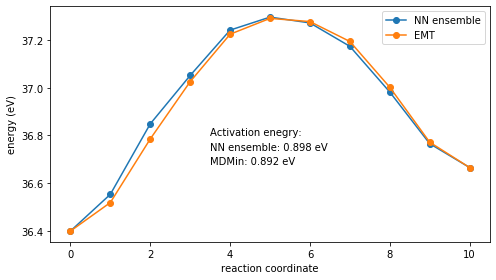

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
ax.plot(range(11), nn_neb_nrgs, '-o')
ax.plot(range(11), mdmin_neb_nrgs, '-o')
ax.set_xlabel('reaction coordinate')
ax.set_ylabel('energy (eV)')
ax.legend(['NN ensemble', 'EMT'])
ax.text(3.5, 36.8, f'Activation enegry: ')
ax.text(3.5, 36.74, f'NN ensemble: {round(nn_neb_nrgs[5] - nn_neb_nrgs[0], 3)} eV')
ax.text(3.5, 36.68, f'MDMin: {round(mdmin_neb_nrgs[5] - mdmin_neb_nrgs[0], 3)} eV')
fig.tight_layout()
fig.savefig('./pt-neb.png', dpi=300)